In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy

In [2]:
def poly(x, *par):
    return np.polyval(par,x)

In [3]:
def cwgp_regression(x, y, cwgp_model):
    kernel = GPy.kern.Matern32(1)

    ratio = 0.9
    length = len(rate)
    train = int(ratio*length)
    train_up, train_low = train, train-train

    res = scipy.optimize.curve_fit(poly,  np.ravel(x[train_low:train_up]), np.ravel(y[train_low:train_up]), p0=(-1,-1))
    par = res[0]
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: poly(x, *par)
    mf.update_gradients = lambda a,b: None


    model = GPy.models.GPRegression(x[train_low:train_up], y[train_low:train_up], mean_function=mf, kernel=kernel)
    model.optimize()

    domain_discrete = np.arange(1940,2031).reshape(-1,1)
    y_res = model.predict(x)
    y_all = model.predict(domain_discrete)
    y_pred= y_res[0]
    y_mean,y_var = y_all[0],y_all[1]
    y_top, y_bot = y_mean + 1.96*np.sqrt(y_var), y_mean - 1.96*np.sqrt(y_var)

    for cwgp in cwgp_model[::-1]:
        y_pred = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_pred)
        y_mean, y_var = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_mean), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_var)
        y_top, y_bot = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_top), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_bot)
        y = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y)


    rmse = mean_squared_error(y[train_up:], y_pred[train_up:], squared=False)
    mae = mean_absolute_error(y[train_up:], y_pred[train_up:])
    txt = f"""rmse : {rmse} \n mae : {mae}"""

    name = [f"{cwgp.phi.fn.__name__}_{cwgp.phi.n}" for cwgp in cwgp_model]
    name = "_".join(name)
    if rmse < 0.003371134608025886:
        domain = np.linspace(1940,2030,91)
        plt.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
        plt.scatter(x[train_low:train_up], y[train_low:train_up], marker="x", color='black', label="data")
        plt.scatter(x[train_up:], y[train_up:], marker="x", color='red')
        plt.plot(np.linspace(1940,2030,91),y_mean, label="mean")
        plt.ylim([0.1,0.35])
        plt.legend()
        plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
        plt.grid(True)
        plt.show()


    print(rmse,mae)
    return rmse, mae

In [4]:
CSV_FIlE = "../japan3.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["rate"].to_numpy().reshape(-1,1)



  0%|          | 0/1296 [00:00<?, ?it/s]

[('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2)]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))


  0%|          | 1/1296 [00:00<14:13,  1.52it/s]

0.0033974795812663264 0.0026830559499519007
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 2))


  0%|          | 2/1296 [00:01<15:19,  1.41it/s]

0.0033974820847672694 0.0026830554340710666
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 1))


  0%|          | 3/1296 [00:02<16:13,  1.33it/s]

0.005566753977688752 0.004985092720804488
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 2))


 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:invalid value encountered in log
 /home/chen/work/venv/lib/python3.6/site-packages/cwgp/phi.py:67: RuntimeWarning:overflow encountered in matmul
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:overflow encountered in sinh
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:overflow encountered in cosh
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:91: RuntimeWarning:overflow encountered in square
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:91: RuntimeWarning:invalid value encountered in true_divide
 /home/chen/work/venv/lib/python3.6/site-packages/cwgp/kernel.py:6: RuntimeWarning:invalid value encountered in subtract
 /home/chen/work/venv/lib/python3.6/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning:invalid value encountered in det
 /home/chen/work/

0.0035633416381172676 0.002720057071868287
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))


  0%|          | 5/1296 [00:28<2:28:50,  6.92s/it]

0.003557033418537441 0.002650914986671538
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 2))


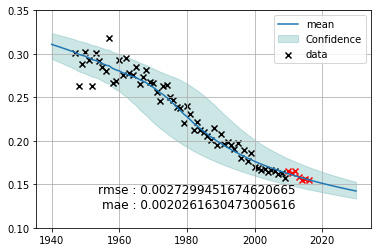

  0%|          | 6/1296 [00:29<1:45:44,  4.92s/it]

0.0027299451674620665 0.0020261630473005616
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 1))


  1%|          | 7/1296 [00:30<1:19:36,  3.71s/it]

0.003397484520368009 0.0026830579684712997
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 2))


  1%|          | 8/1296 [00:31<1:01:28,  2.86s/it]

0.003397483466559857 0.0026830571557730576
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 1))


  1%|          | 9/1296 [00:32<50:29,  2.35s/it]  

0.005566685133579589 0.004985009106082239
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 2))


 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:invalid value encountered in log
 /home/chen/work/venv/lib/python3.6/site-packages/cwgp/phi.py:67: RuntimeWarning:overflow encountered in matmul
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:overflow encountered in sinh
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:overflow encountered in cosh
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning:overflow encountered in multiply
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:91: RuntimeWarning:overflow encountered in square
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:91: RuntimeWarning:invalid value encountered in true_divide
 /home/chen/work/venv/lib/python3.6/site-packages/cwgp/kernel.py:6: RuntimeWarning:invalid value encountered in subtract
 /home/chen/w

0.0049461008577281074 0.004202375481830548
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 1))


  1%|          | 11/1296 [00:41<1:05:56,  3.08s/it]

0.0035570572384997614 0.0026509066401727366
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 2))


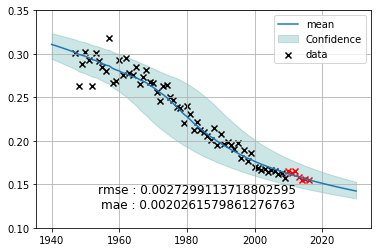

  1%|          | 12/1296 [00:42<52:19,  2.45s/it]  

0.0027299113718802595 0.0020261579861276763
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 1))


  1%|          | 13/1296 [00:43<42:13,  1.97s/it]

0.005548526514751663 0.00496418021526006
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 2))


 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:invalid value encountered in log
  1%|          | 14/1296 [00:44<34:46,  1.63s/it]

0.02687442599719323 0.026114380529594115
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 1))


  1%|          | 15/1296 [00:45<31:17,  1.47s/it]

0.00444822942189491 0.0035409332726921506
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 2))


 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:invalid value encountered in log
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:overflow encountered in sinh
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:overflow encountered in cosh
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:91: RuntimeWarning:overflow encountered in square
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:91: RuntimeWarning:invalid value encountered in true_divide
 /home/chen/work/venv/lib/python3.6/site-packages/cwgp/kernel.py:6: RuntimeWarning:invalid value encountered in subtract
 /home/chen/work/venv/lib/python3.6/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning:invalid value encountered in det
 /home/chen/work/venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning:overflow encountered in multiply
 /home/c

In [ ]:
result = grid_search(cwgp_regression, year, rate, {"c":4,"n":[1,2],"transformations":["sa","sal","box_cox"]})
